In [2]:
import numpy as np
dataset = "NYCTaxi"
data_path = fr"D:\omer\ST-SSL\data\{dataset}\train.npz"
x_train = np.load(data_path)["x"]
y_train = np.load(data_path)["y"]
extreme_values_binary_tensor = np.load(data_path)["evs_90"]
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, evs.shape: {extreme_values_binary_tensor.shape}")

x_train shape: (1912, 35, 200, 2), y_train shape: (1912, 1, 200, 2), evs.shape: (1912, 1, 200, 2)


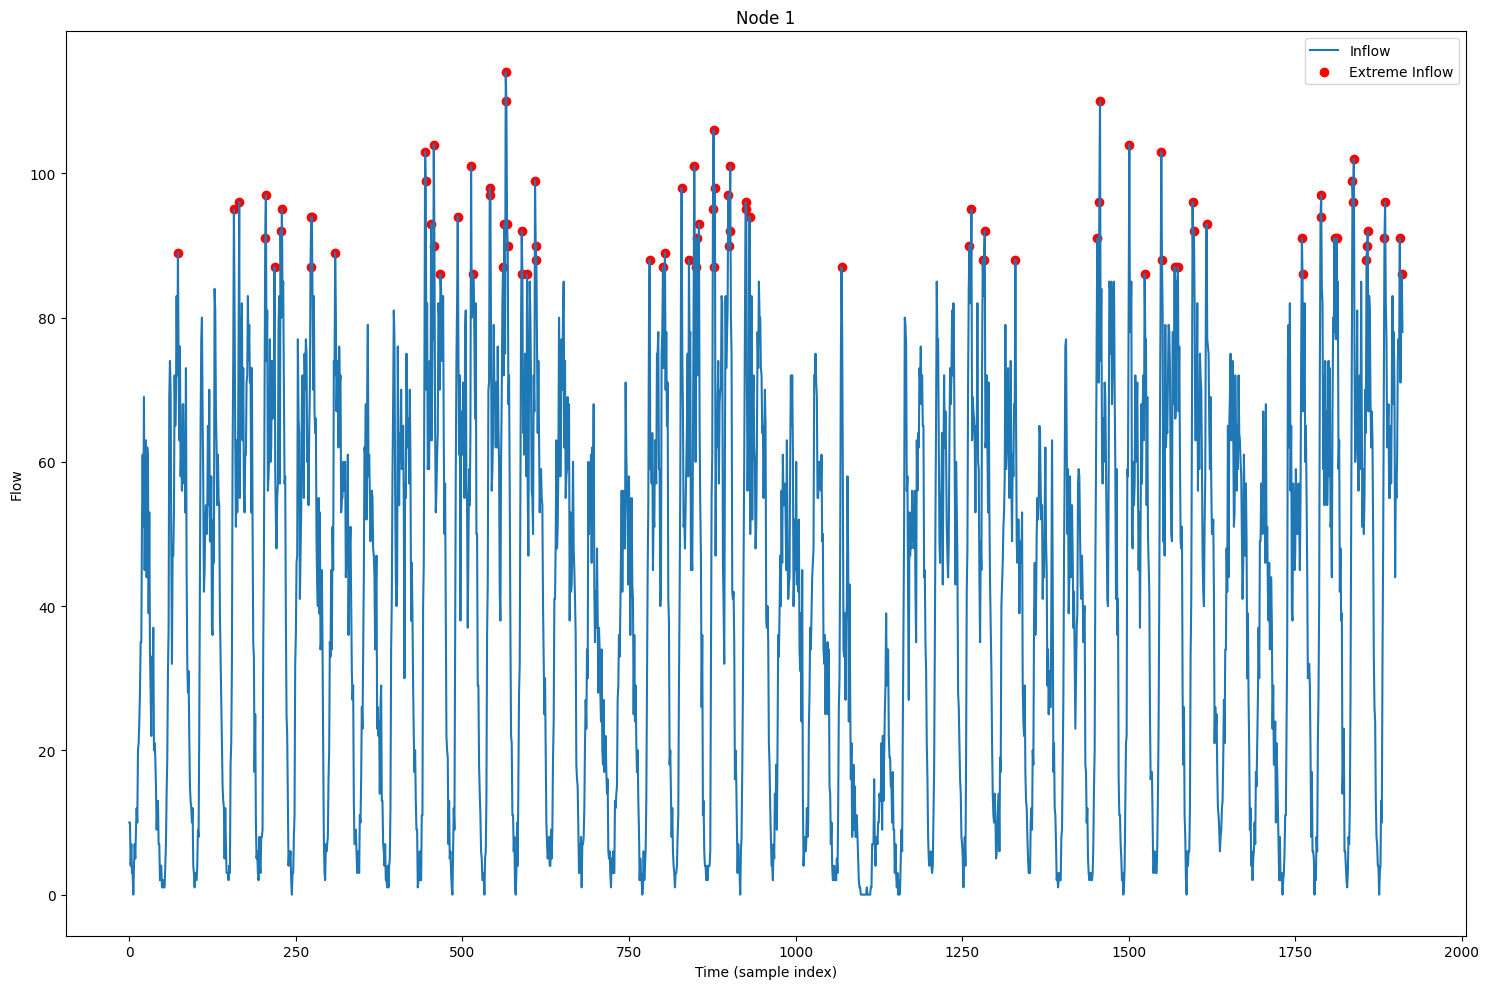

In [28]:
## plot from the gt EVs

import numpy as np
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(15, 10))

# Plotting for the first node (as the loop range is 1, it plots only the first node)
for node_index in range(1):
    inflow = y_train[:, 0, node_index, 0]
    outflow = y_train[:, 0, node_index, 1]
    
    # Extract extreme indicators for inflow and outflow
    extreme_inflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 0]
    # extreme_outflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 1]
    
    # Identify indices where extreme events occur
    extreme_inflow_indices = np.where(extreme_inflow_indicator == 1)[0]
    # extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

    # Plotting inflow and outflow
    plt.subplot(1, 1, node_index + 1)
    plt.plot(inflow, label='Inflow')
    # plt.plot(outflow, label='Outflow')

    # Marking the extreme events
    plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow', marker='o')
    # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')

    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()

plt.tight_layout()
plt.show()


## plotting evs from the learnt classifier

In [29]:


import warnings 
warnings.filterwarnings('ignore')
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('.')
sys.path.append('..')
import yaml 
import argparse
import traceback
import time
import torch

from model.models import STSSL
from model.trainer import Trainer
from lib.dataloader import get_dataloader
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

In [30]:
import time
import yaml

# Define your configurations directly
configs = {
    'config_filename': 'configs/NYCTaxi.yaml',
    'S_Loss': 0,
    'T_Loss': 0,
    'seed': 1,
    'comment': "testing",
    'cheb_order': 3,
    'graph_init': "8_neighbours",
    'self_attention_flag': True,
    'cross_attention_flag': False,
    'feedforward_flag': False,
    'layer_norm_flag': False,
    'additional_sa_flag': False,
    'learnable_flag': False,
    'rank': 0,
    'pos_emb_flag': False,
    'add_8': True,
    'add_eye': False,
    'add_x_encoder': False,
    'freeze_encoder': False,
    'ipe': 1,
    "mode": "test"
}

# Optionally print the starting experiment configurations
print(f"Starting experiment with configurations in {configs['config_filename']}...")

# Simulate a brief pause
time.sleep(3)

# Load configurations from a file (if necessary, or you could just use the dictionary as is)
with open(configs['config_filename'], 'r') as file:
    file_configs = yaml.load(file, Loader=yaml.FullLoader)
    configs.update(file_configs)

# You can add logic to modify configurations based on your conditions here
experiment_name = "pred_"
if configs['S_Loss'] == 1:
    experiment_name += "+S"
if configs['T_Loss'] == 1:
    experiment_name += "+T"
experiment_name += f"_seed={configs['seed']}"

configs['comment'] = "noComment"
configs['ipe'] = 1000
configs['loss'] = "mae"
configs['threshold_adj_mx'] = False
configs['affinity_conv'] = False
configs["experimentName"] = experiment_name
configs["mode"] = "test"
configs["load_path"] = None

# Print the final configuration to start the experiment
print(f"Starting experiment with configurations {configs}...")
args = argparse.Namespace(**configs)

Starting experiment with configurations in configs/NYCTaxi.yaml...
Starting experiment with configurations {'config_filename': 'configs/NYCTaxi.yaml', 'S_Loss': 0, 'T_Loss': 0, 'seed': 1, 'comment': 'noComment', 'cheb_order': 3, 'graph_init': '8_neighbours', 'self_attention_flag': True, 'cross_attention_flag': False, 'feedforward_flag': False, 'layer_norm_flag': False, 'additional_sa_flag': False, 'learnable_flag': False, 'rank': 0, 'pos_emb_flag': False, 'add_8': True, 'add_eye': False, 'add_x_encoder': False, 'freeze_encoder': False, 'ipe': 1000, 'mode': 'test', 'device': 'cuda', 'best_path': 'None', 'debug': False, 'data_dir': 'data', 'dataset': 'NYCTaxi', 'input_length': 35, 'batch_size': 32, 'test_batch_size': 32, 'graph_file': 'data/NYCTaxi/adj_mx.npz', 'num_nodes': 200, 'row': 20, 'col': 10, 'd_input': 2, 'd_output': 2, 'd_model': 64, 'dropout': 0.1, 'percent': 0.1, 'shm_temp': 0.5, 'nmb_prototype': 4, 'yita': 0.5, 'start_epoch': 0, 'num_epochs': 1000, 'epochs': 1000, 'lr_init':

In [31]:
init_seed(args.seed)
if not torch.cuda.is_available():
    args.device = 'cuda'

## load dataset
dataloader = get_dataloader(
    data_dir=args.data_dir, 
    dataset=args.dataset, 
    batch_size=args.batch_size, 
    test_batch_size=args.test_batch_size,
    scalar_type='Standard'
)
graph = load_graph(args.graph_file, device=args.device)
args.num_nodes = len(graph)

## init model and set optimizer
model = STSSL(args).to(args.device)

args.best_path = r'D:\omer\ST-SSL\experiments\NYCTaxi\pred__seed=1\20240719-155344\evl (cheating)\best_model.pth'
state_dict = torch.load(
                args.best_path,
                map_location=torch.device(args.device)
            )
msg = model.load_state_dict(state_dict['model'])
print("Load saved model msg: ", msg)

model_parameters = get_model_params([model])
optimizer = torch.optim.Adam(
    params=model_parameters, 
    lr=args.lr_init, 
    eps=1.0e-8, 
    weight_decay=0, 
    amsgrad=False
)



!!Scaling is NOT off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is True!!


in else
in else
Load saved model msg:  <All keys matched successfully>


In [32]:
## start training
trainer = Trainer(
    model=model, 
    optimizer=optimizer, 
    dataloader=dataloader,
    graph=graph, 
    args=args
)

2024-07-25 15:02:54: 
Model has 1.158604 M trainable parameters
2024-07-25 15:02:54: Experiment log path in: D:\omer\ST-SSL\experiments\NYCTaxi\pred__seed=1\20240725-150254\noComment
2024-07-25 15:02:54: Experiment configs are: Namespace(S_Loss=0, T_Loss=0, add_8=True, add_eye=False, add_x_encoder=False, additional_sa_flag=False, affinity_conv=False, batch_size=32, best_path='D:\\omer\\ST-SSL\\experiments\\NYCTaxi\\pred__seed=1\\20240719-155344\\evl (cheating)\\best_model.pth', cheb_order=3, col=10, comment='noComment', config_filename='configs/NYCTaxi.yaml', cross_attention_flag=False, d_input=2, d_model=64, d_output=2, data_dir='data', dataset='NYCTaxi', debug=False, device='cuda', dropout=0.1, early_stop=True, early_stop_patience=20, epochs=1000, experimentName='pred__seed=1', feedforward_flag=False, freeze_encoder=False, grad_norm=True, graph_file='data/NYCTaxi/adj_mx.npz', graph_init='8_neighbours', input_length=35, ipe=1000, layer_norm_flag=False, learnable_flag=False, load_path=

dummy forward pass done.
Creat Log File in:  D:\omer\ST-SSL\experiments\NYCTaxi\pred__seed=1\20240725-150254\noComment\run.log


In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    evs_true = []
    evs_pred = []
    y_pred = []
    y_true = []
    bias_pred = []
    with torch.no_grad():
        for batch_idx, (data, target, evs) in enumerate(dataloader):
            repr1 = model(data, graph)                
            pred_output = model.predict(repr1, evs)
            # evs_predicted = model.get_evs(repr1_cls)
            bias = model.get_bias(repr1)
            y_true.append(target)
            y_pred.append(pred_output)
            evs_true.append(evs)
            evs_pred.append(evs)
            bias_pred.append(bias)

    # y_true = torch.cat(y_true, dim=0).cpu().numpy()
    # y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    evs_true = torch.cat(evs_true, dim=0).cpu().numpy()
    evs_pred = torch.cat(evs_pred, dim=0).cpu().numpy()
    bias_pred = torch.cat(bias_pred, dim=0).cpu().numpy()
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()
    # bias_pred = scaler.inverse_transform(torch.cat(bias_pred, dim=0)).cpu().numpy()
    mask = np.where(y_true > (5), True, False)
    # true = true[mask]
    # pred = pred[mask]
    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("test, MAE: {:.2f}, test MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    
    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:4000], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:4000], label='Predictions')
    ## to plot summed up regions
    # plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten()
    #         , label='True Values')
    # plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    mask = y_true > 5

    # Apply the mask to y_true and y_pred to filter values
    masked_y_true = np.where(mask, y_true, np.nan)  # Replace unmasked values with NaN
    masked_y_pred = np.where(mask, y_pred, np.nan)  # Same for y_pred
    print("masked_y_true.shape: ", masked_y_true.shape, "masked_y_pred.shape: ", masked_y_pred.shape)
    # Sum and flatten the masked values for plotting
    # Using np.nansum to ignore NaN values in summation
    summed_masked_y_true = np.nansum(masked_y_true, axis=2).flatten()
    summed_masked_y_pred = np.nansum(masked_y_pred, axis=2).flatten()
    plt.plot(summed_masked_y_true, label='True Values (Masked)', color='blue', linewidth=2, linestyle='-')
    plt.plot(summed_masked_y_pred, label='Predictions (Masked)', color='red', linewidth=2, linestyle='--')
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0), y_true, y_pred, evs_true, evs_pred, bias_pred


2024-07-25 15:04:14: test, MAE: 11.15, test MAPE: 15.4658%


y_true.shape:  (546, 1, 200, 2) y_pred.shape:  (546, 1, 200, 2)
masked_y_true.shape:  (546, 1, 200, 2) masked_y_pred.shape:  (546, 1, 200, 2)


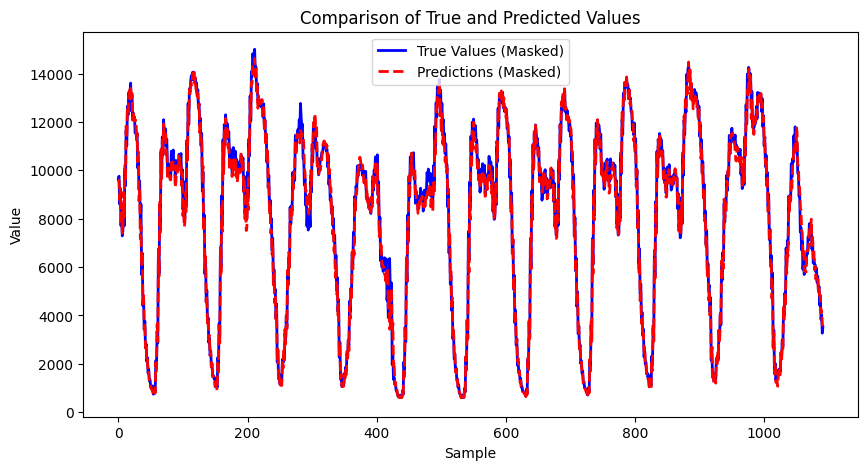

2024-07-25 15:04:14: OUTFLOW, MAE: 8.99, MAPE: 15.5038%


In [38]:
_, y_true, y_pred, evs_true, evs_pred, bias_pred = test(model, dataloader['test'], dataloader['scaler'], graph, trainer.logger, args)

<Figure size 5500x5000 with 0 Axes>

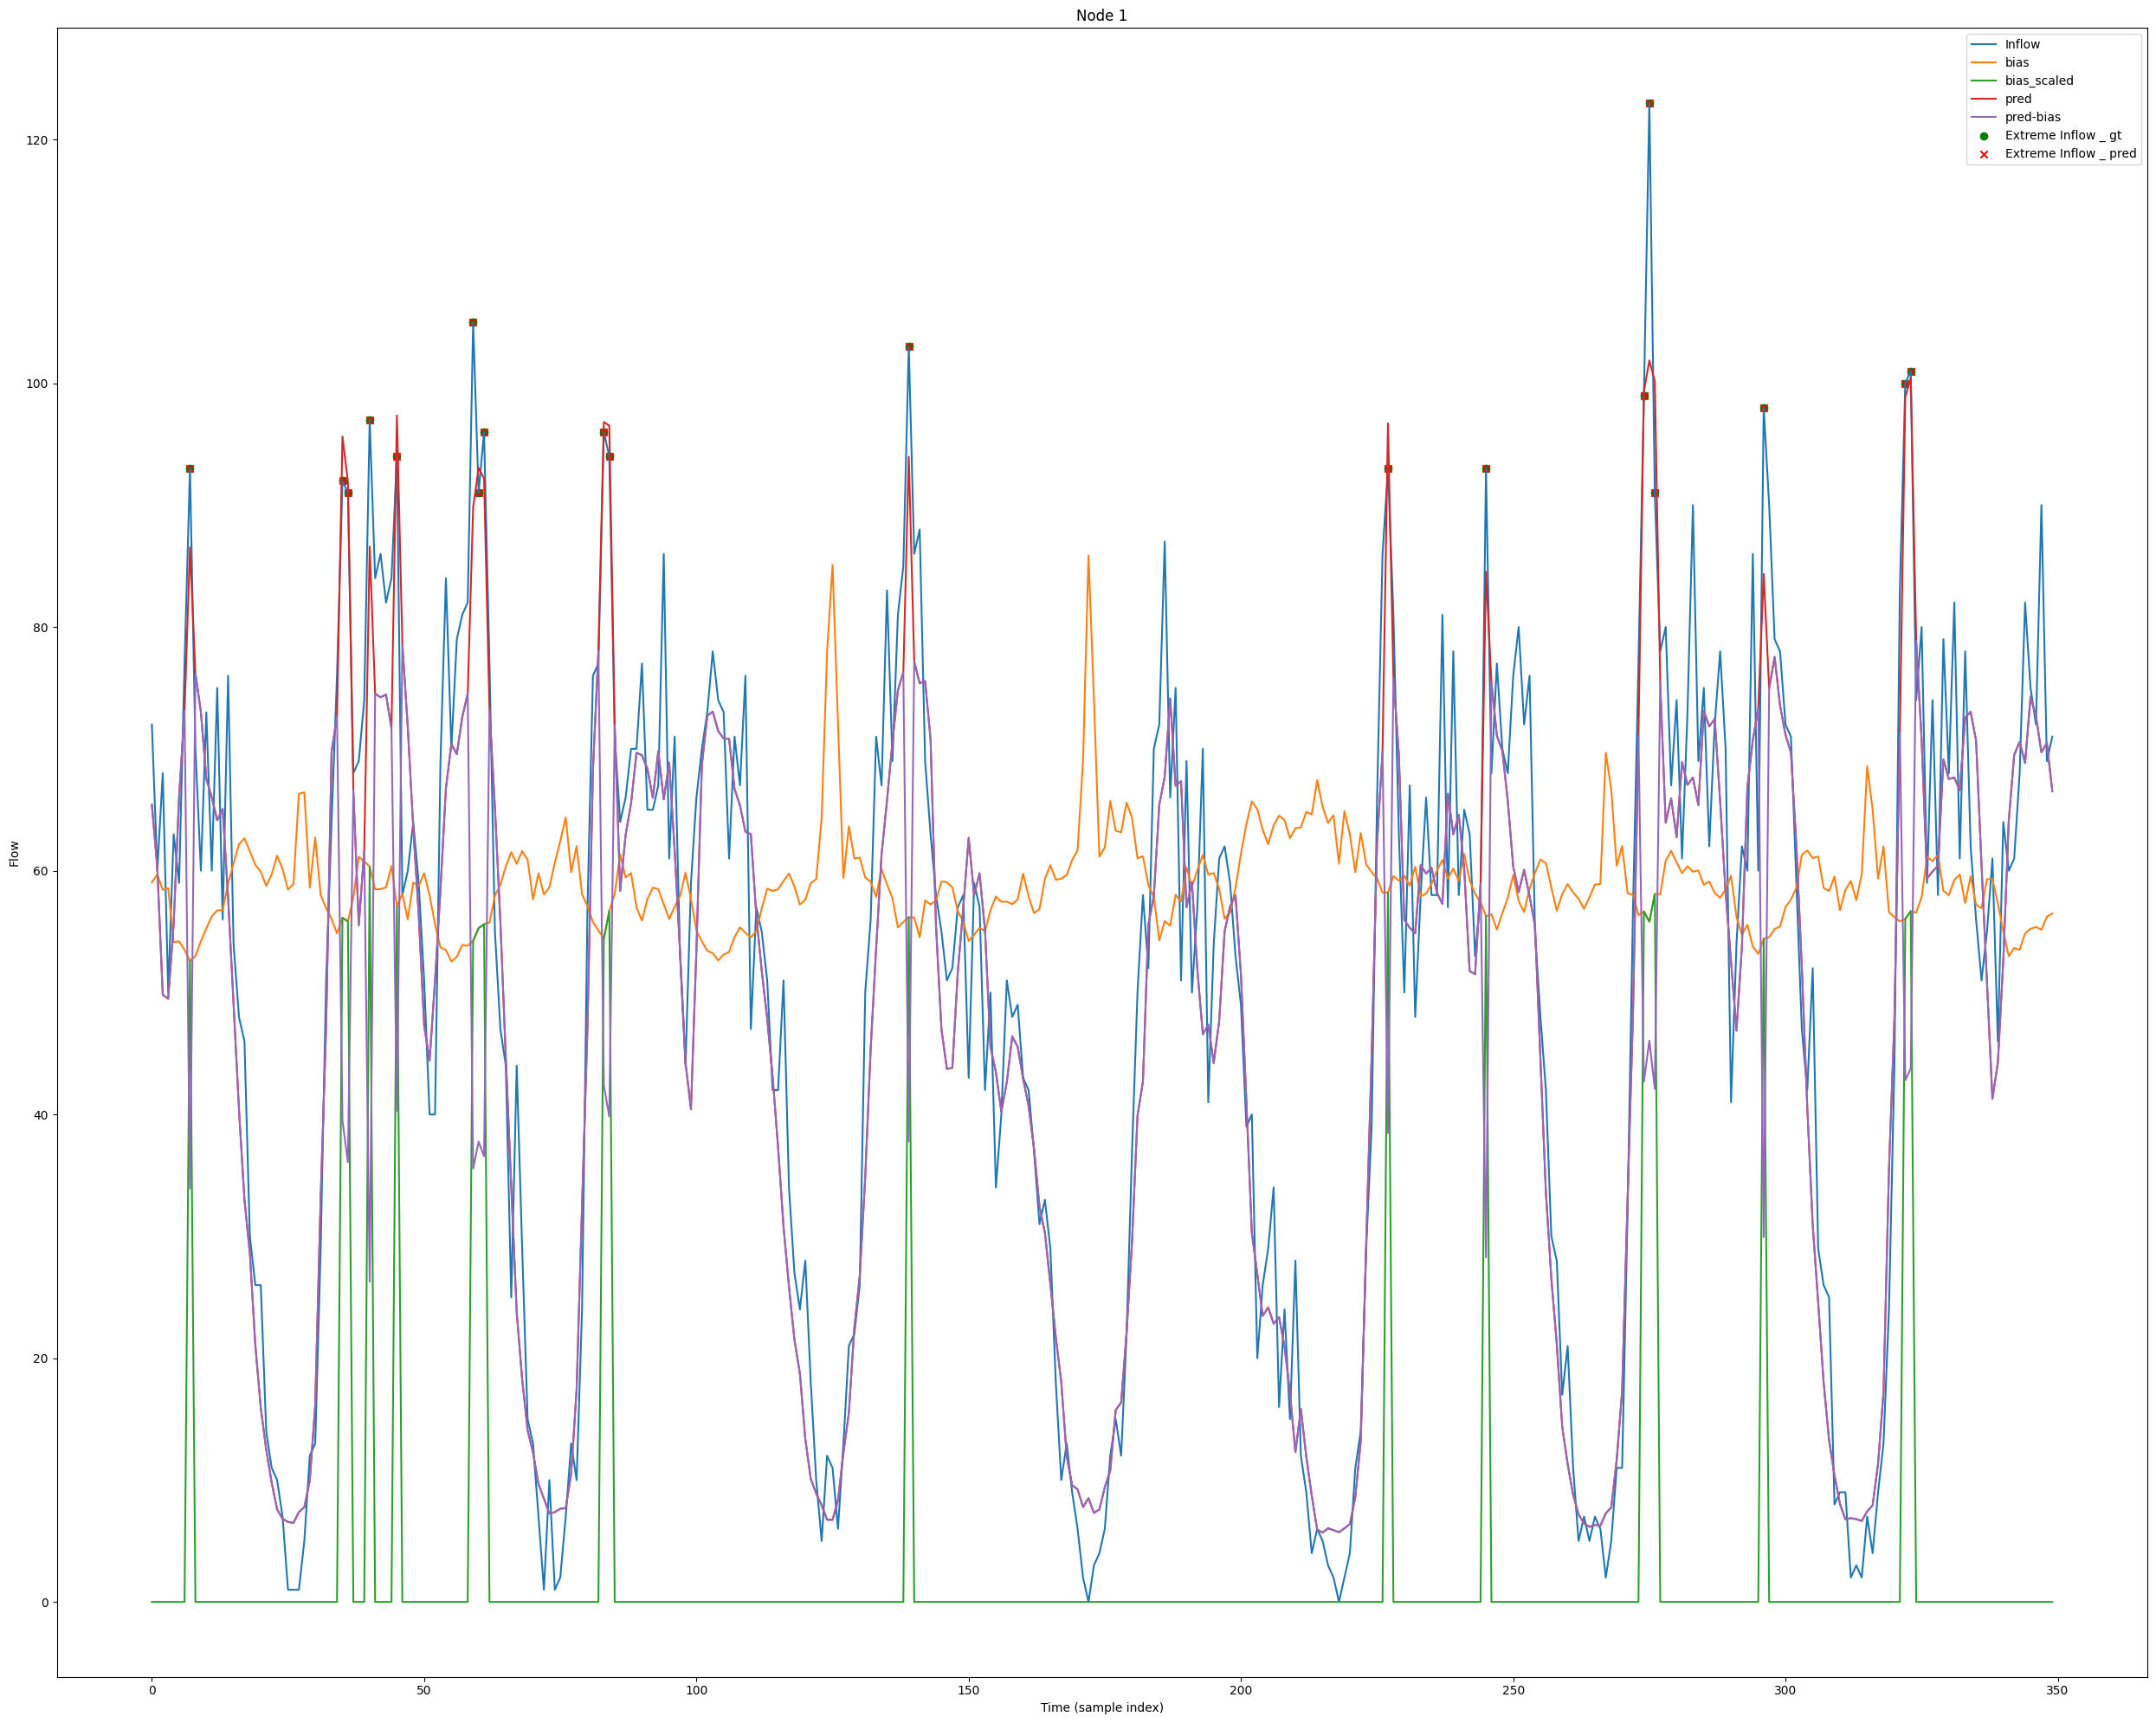

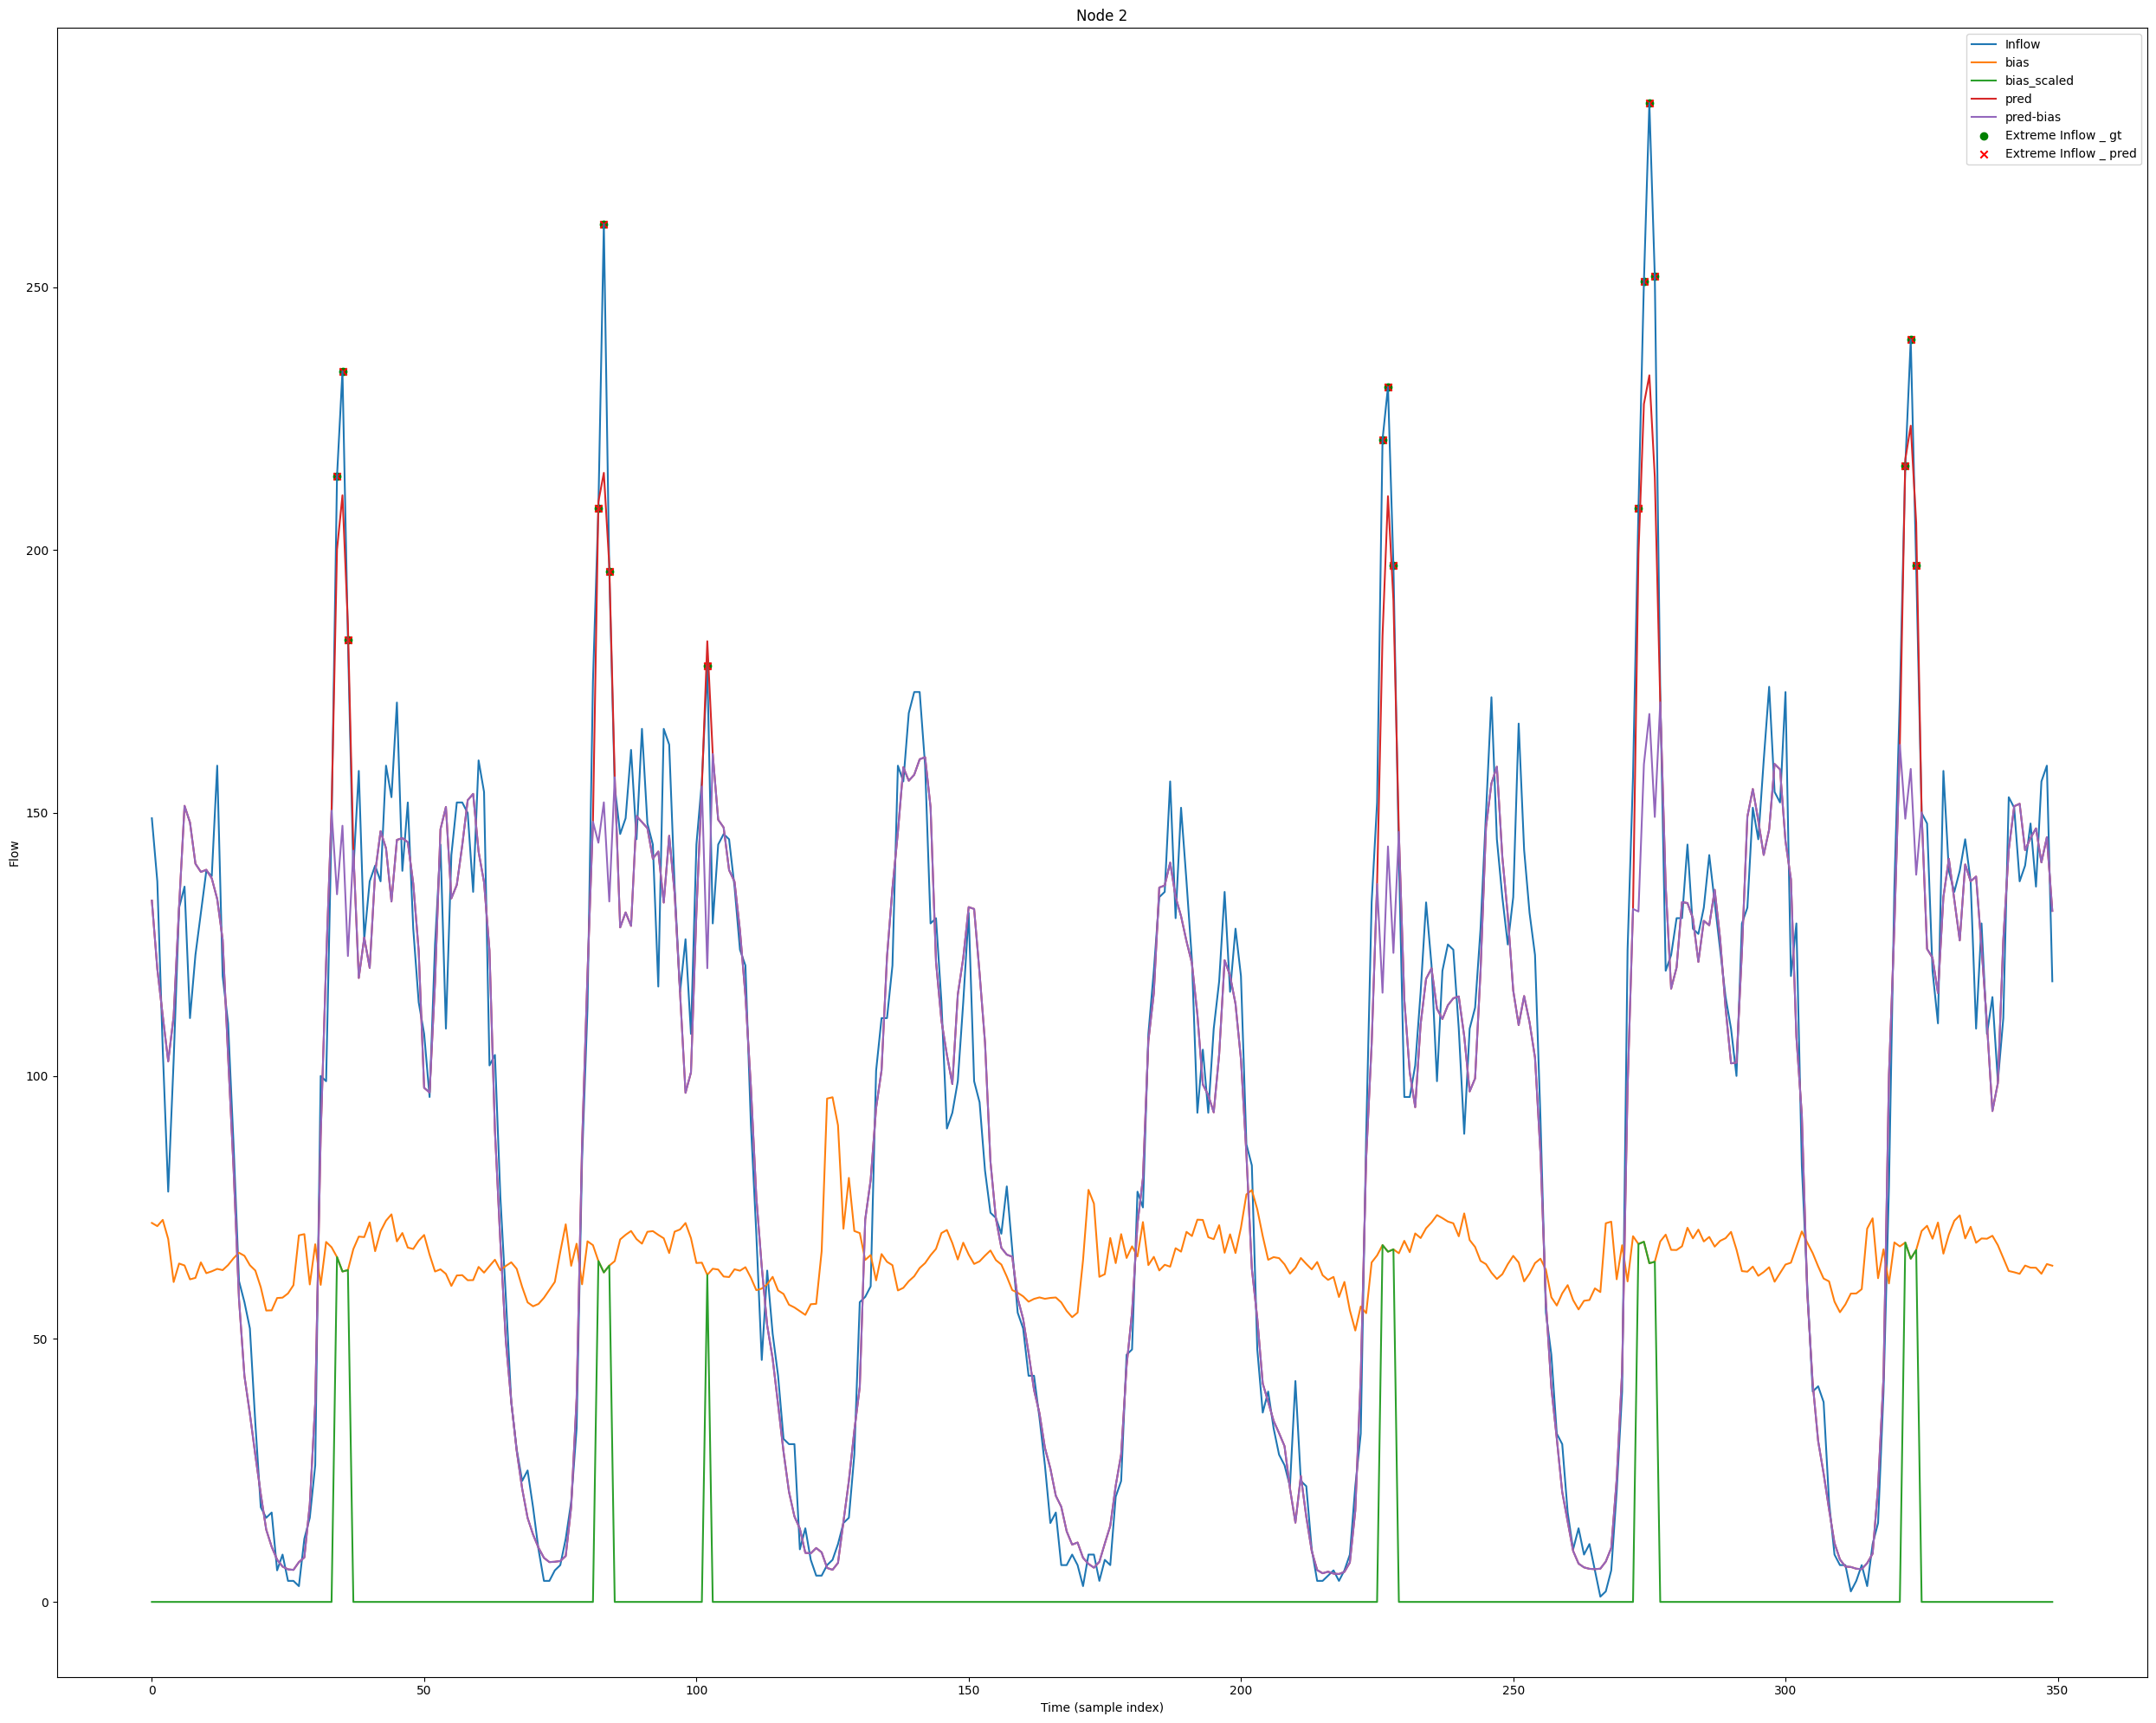

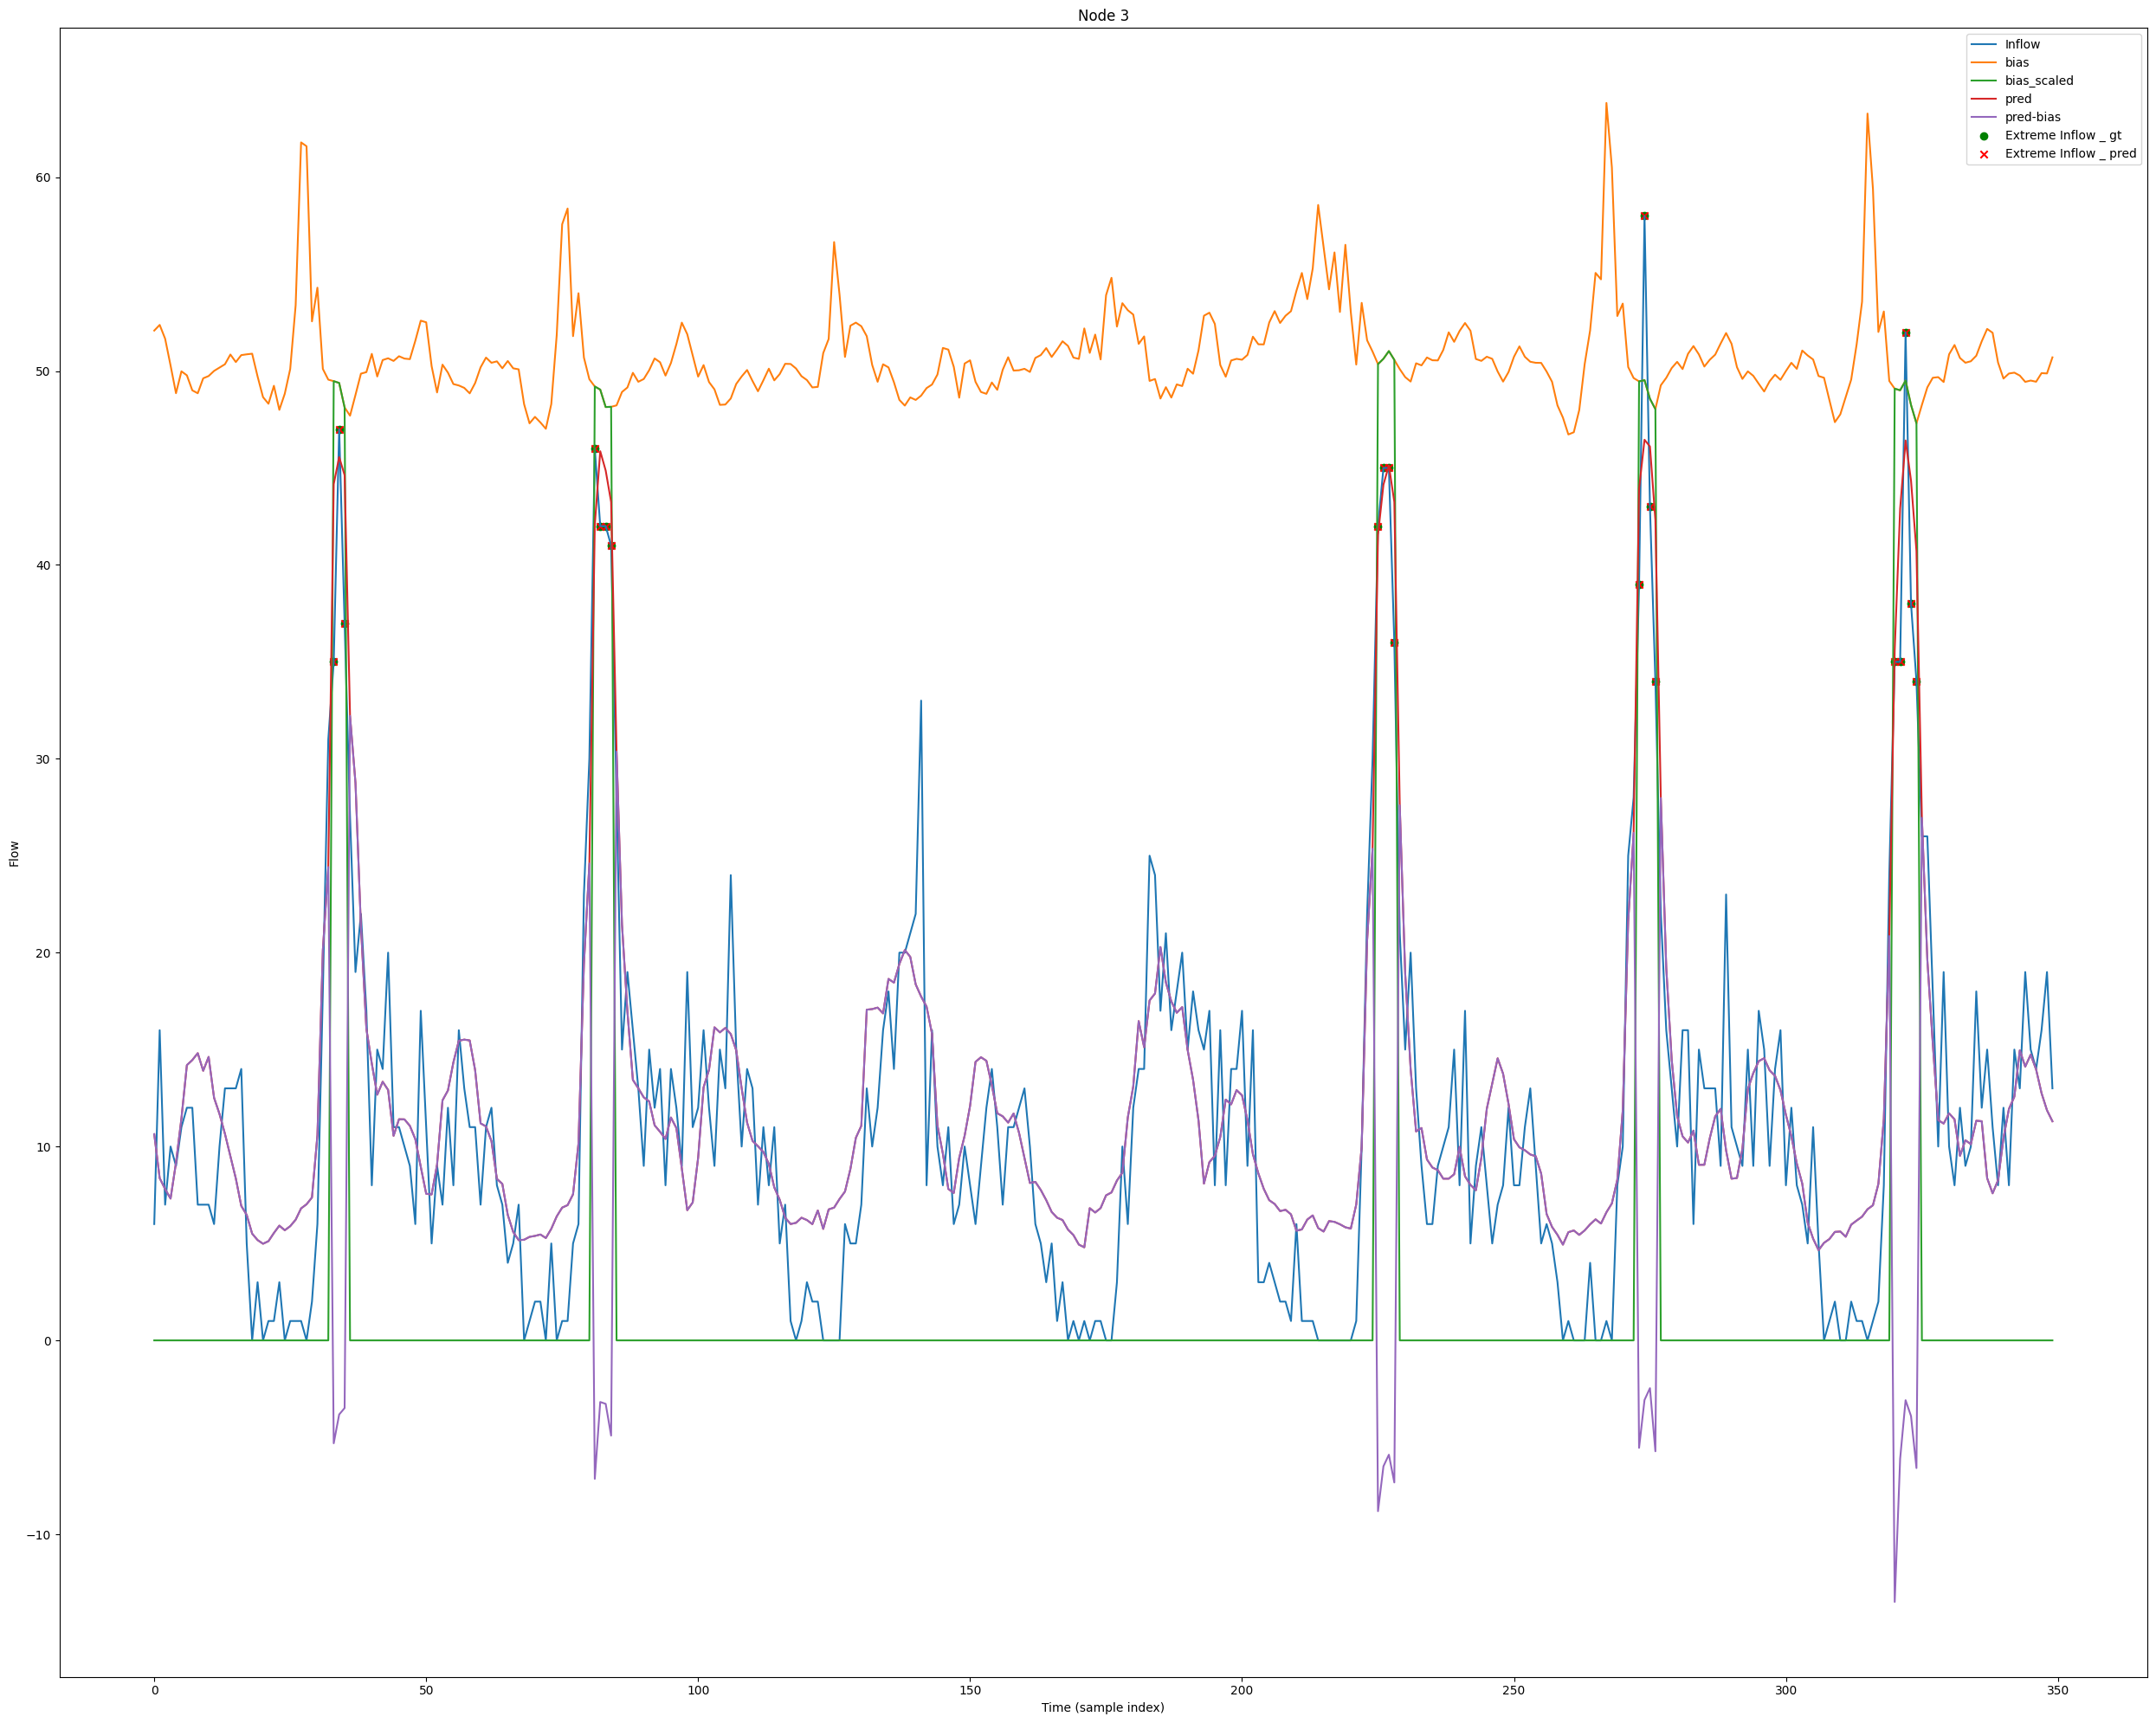

In [41]:
## plot from the newly defined binary tensor

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train and extreme_indicator_tensor are defined with the same shape
# and extreme_indicator_tensor contains 1 where there's an extreme event and 0 otherwise

# Set up the plot
plt.figure(figsize=(55, 50))

# Plotting for the first node (as the loop range is 1, it plots only the first node)
for node_index in range(3):
    plt.figure(figsize=(25, 20))

    start, end = 0, 350
    inflow = y_true[start:end, 0, node_index, 0]
    ## actual inflow
    inflow_node = y_true[start:end, 0, node_index, 0]
    plt.plot(inflow_node, label='Inflow')

    ## predicted bias to add in inflow
    bias_pred_node = bias_pred[start:end, 0, node_index, 0]
    bias_pred_scaled = dataloader['scaler'].inverse_transform(bias_pred_node)
    plt.plot(bias_pred_scaled, label='bias')

    ## predicted bias scaled by the indicator
    extreme_inflow_indicator = evs_pred[start:end, 0, node_index, 0]
    bias_pred_node_scaled = bias_pred_scaled * extreme_inflow_indicator
    plt.plot(bias_pred_node_scaled, label='bias_scaled')
    
    ## difference between the actual inflow and the predicted inflow
    inflow_pred_node = y_pred[start:end, 0, node_index, 0]
    diff = inflow_node - inflow_pred_node
    plt.plot(inflow_pred_node, label='pred')

    ## prediction - bias
    pred_bias = inflow_pred_node - bias_pred_node_scaled
    plt.plot(pred_bias, label='pred-bias')

    extreme_inflow_indicator_true = evs_true[start:end, 0, node_index, 0]
    bias_pred_node = bias_pred[start:end, 0, node_index, 0]

    # Identify indices where extreme events occur
    extreme_inflow_indices = np.where(extreme_inflow_indicator >= .5)[0]
    extreme_inflow_indices_true = np.where(extreme_inflow_indicator_true == 1)[0]
    # extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

    # Plotting inflow and outflow
    
    
    # plt.plot(outflow, label='Outflow')

    # Marking the extreme events
    plt.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='green', label='Extreme Inflow _ gt', marker='o')
    plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow _ pred', marker='x')
    
    # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')

    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()
    plt.tight_layout()
    plt.show()




In [ ]:
## plot from the newly defined binary tensor

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train and extreme_indicator_tensor are defined with the same shape
# and extreme_indicator_tensor contains 1 where there's an extreme event and 0 otherwise

# Set up the plot
plt.figure(figsize=(15, 10))

# Plotting for the first node (as the loop range is 1, it plots only the first node)
for node_index in range(1):
    inflow = y_true[:, 0, node_index, 0]
    # outflow = y_train[:, 0, node_index, 1]
    
    # Extract extreme indicators for inflow and outflow
    extreme_inflow_indicator = evs_pred[:, 0, node_index, 0]
    extreme_inflow_indicator_true = evs_true[:, 0, node_index, 0]
    # print("extreme_inflow_indicator", extreme_inflow_indicator)
    # extreme_outflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 1]
    
    # Identify indices where extreme events occur
    extreme_inflow_indices = np.where(extreme_inflow_indicator >= .2)[0]
    extreme_inflow_indices_true = np.where(extreme_inflow_indicator_true == 1)[0]
    # extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

    # Plotting inflow and outflow
    plt.subplot(1, 1, node_index + 1)
    plt.plot(inflow, label='Inflow')
    # plt.plot(outflow, label='Outflow')

    # Marking the extreme events
    plt.scatter(extreme_inflow_indices_true, inflow[extreme_inflow_indices_true], color='green', label='Extreme Inflow _ gt', marker='o')
    plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow _ pred', marker='x')
    
    # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')

    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()

plt.tight_layout()
plt.show()


evaluating the classifier

In [ ]:
# evs_true, evs_pred
# evs_true.shape

import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
                             balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc)
# Threshold predictions at 0.2
evs_pred_binary = (evs_pred >= 0.25).astype(int)

# Flatten the arrays to fit the metrics functions
evs_true_flat = evs_true.flatten()
evs_pred_flat = evs_pred_binary.flatten()
evs_pred_probs_flat = evs_pred.flatten()  # Use raw probabilities for AUC and precision-recall calculations

# Calculate metrics
accuracy = accuracy_score(evs_true_flat, evs_pred_flat)
precision = precision_score(evs_true_flat, evs_pred_flat)
recall = recall_score(evs_true_flat, evs_pred_flat)
f1 = f1_score(evs_true_flat, evs_pred_flat)
balanced_acc = balanced_accuracy_score(evs_true_flat, evs_pred_flat)
roc_auc = roc_auc_score(evs_true_flat, evs_pred_probs_flat)

# Precision-Recall Curve and AUC
precision_points, recall_points, _ = precision_recall_curve(evs_true_flat, evs_pred_probs_flat)
auc_pr = auc(recall_points, precision_points)

# Display the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Balanced Accuracy:", balanced_acc)
print("ROC AUC:", roc_auc)
print("Precision-Recall AUC:", auc_pr)



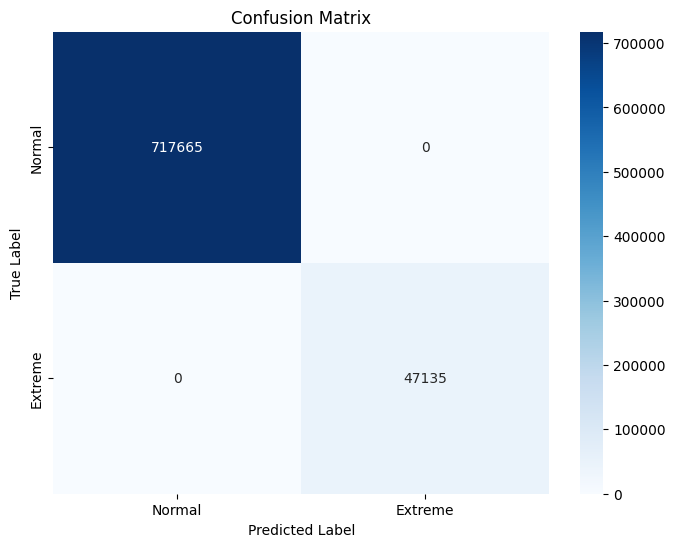

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
evs_true=extreme_values_binary_tensor
# Example data, replace these with your actual data
# evs_pred_binary = (evs_pred >= 0.25).astype(int)       # Threshold predictions at 0.2
evs_pred_binary = extreme_values_binary_tensor       
# Flatten the arrays
evs_true_flat = evs_true.flatten()
evs_pred_flat = evs_pred_binary.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(evs_true_flat, evs_pred_flat)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Normal", "Extreme"], yticklabels=["Normal", "Extreme"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
for t in np.arange(0, 1, 0.05):
    # Example data, replace these with your actual data
    print(t)
    evs_pred_binary = (evs_pred >= t).astype(int)       # Threshold predictions at 0.2

    # Flatten the arrays
    evs_true_flat = evs_true.flatten()
    evs_pred_flat = evs_pred_binary.flatten()

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(evs_true_flat, evs_pred_flat)

    # Plotting the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Normal", "Extreme"], yticklabels=["Normal", "Extreme"])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
